In [14]:
# Dependencies
import tweepy
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import (consumer_key, consumer_secret, access_token, access_token_secret) 
import numpy as np
import seaborn as sns
from datetime import datetime

In [4]:
# Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyze = SentimentIntensityAnalyzer()

In [5]:
# Set up Twitter workspace
keys = tweepy.OAuthHandler(consumer_key, consumer_secret)
keys.set_access_token(access_token, access_token_secret)
api = tweepy.API(keys, parser=tweepy.parsers.JSONParser())

In [6]:
# Reference twitter users
targets = ("CNN", "BBC", "CBS", "FoxNews", "NYTimes")

In [7]:
sentiments ={}

In [8]:
for user in targets:
    
    dates = []
    texts = []
    sources = []
    compound = []
    positive = []
    negative = []
    neutral = []
    tweet_ago = []
    
    # Counter
    counter = 0
    
    # Loop 100 tweets for each Media 
    for x in range(5):
        
        # Read the API for Media Sources
        public_tweets = api.user_timeline(user, page = x)
        
        for tweet in public_tweets:
                       
            #Delete hashtag below to print out tweets
            # print(json.dumps(tweet, indent = 4, sort_keys = True))
            
            # Append empty lists 
            dates.append(tweet['created_at'])
            texts.append(tweet['text'])
            sources.append(tweet['source'])
            
            
            results = analyze.polarity_scores(tweet["text"])
            com = results["compound"]
            pos = results["pos"]
            neg = results["neg"]
            neu = results["neu"]
            
            compound.append(com)
            positive.append(pos)
            negative.append(neg)
            neutral.append(neu)
            
            # Add 1 to counter for tweet ago
            counter += 1
            tweet_ago.append(counter)
    
    # Fill in Sentiments dictionary
    sentiments[user]=(tweet_ago, dates, texts, sources, compound, positive, negative, neutral)

In [9]:
# Function for holding values from Sentiment dictionary

def news(user):
    data = {'Tweet Ago': sentiments[user][0],
           'Date': sentiments[user][1],
           'Text': sentiments[user][2],
           'Source': sentiments[user][3],
           'Compound': sentiments[user][4],
           'Positive': sentiments[user][5],
           'Negative': sentiments[user][6],
           'Neutral': sentiments[user][7],
            'Target': user, 
               }
    return(pd.DataFrame(data))

In [10]:
# Set up Sentiments dictionary columns 
column_names = ['Target', 'Tweet Ago', 'Date', 'Compound',
                'Positive', 'Negative', 'Neutral', 'Text',
                'Source']

clean_sentiments = pd.DataFrame(columns = column_names)

In [13]:
# Loop Media Sources 
for user in targets:
    clean_sentiments = clean_sentiments.append(news(user))

In [15]:
# Timestamp conversion 
clean_sentiments['Date'] = pd.to_datetime(clean_sentiments['Date'])

In [16]:
# Create new Data Frame
clean_sentiments = pd.DataFrame(clean_sentiments, columns = ['Target', 'Date', 'Tweet Ago', 'Compound',
                                                             'Positive', 'Negative', 'Neutral', 'Text', 'Source'])
select_data = clean_sentiments

In [17]:
# Generate Data Frames per media source

data_BBC = select_data.loc[select_data['Target'] == 'BBC']
data_CBS = select_data.loc[select_data['Target'] == 'CBS']
data_CNN = select_data.loc[select_data['Target'] == 'CNN']
data_FoxNews = select_data.loc[select_data['Target'] == 'FoxNews']
data_nytimes = select_data.loc[select_data['Target'] == 'nytimes']

In [19]:
# Concatinate each Data Frames 
frames = [data_BBC, data_CBS, data_CNN, data_FoxNews, data_nytimes]
big_data = pd.concat(frames)
big_data.to_csv('SentimentAnalysisData.csv')

In [23]:
big_data.head()

,Target,Date,Tweet Ago,Compound,Positive,Negative,Neutral,Text,Source
0,BBC,2018-01-15 20:12:31,1,0.5267,0.175,0.000,0.825,RT @BBCNewsbeat: Cyrille Regis was an inspirat...,"<a href=""http://twitter.com/download/iphone"" r..."
1,BBC,2018-01-15 20:09:52,2,-0.2942,0.052,0.101,0.847,RT @bbcasiannetwork: 🇮🇳 @HarpreetUK has got th...,"<a href=""http://twitter.com/download/iphone"" r..."
2,BBC,2018-01-15 20:08:50,3,0.3382,0.165,0.109,0.726,RT @mixital: This week's @bbceastenders story ...,"<a href=""http://twitter.com/download/iphone"" r..."
3,BBC,2018-01-15 20:08:25,4,-0.4588,0.109,0.239,0.652,RT @cbbc: Find out what it's like having a dad...,"<a href=""http://twitter.com/download/iphone"" r..."
4,BBC,2018-01-15 19:17:04,5,0.0000,0.000,0.000,1.000,📚 Discover the life story and work of Irish no...,"<a href=""http://www.radian6.com"" rel=""nofollow..."


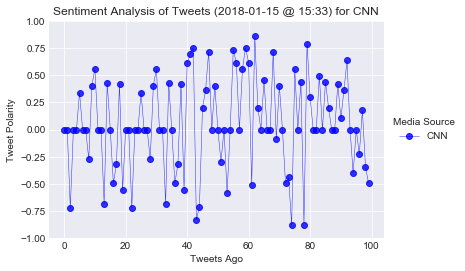

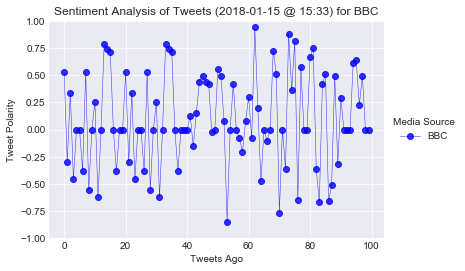

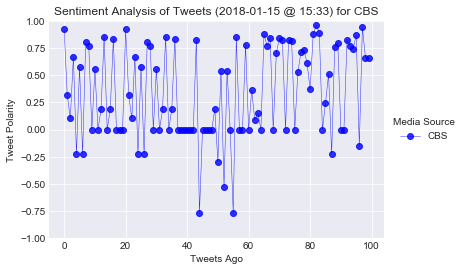

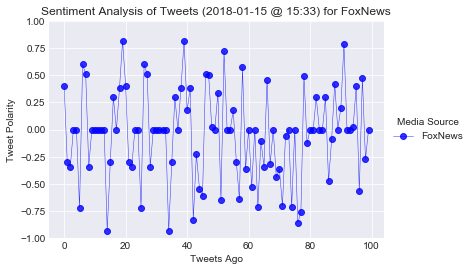

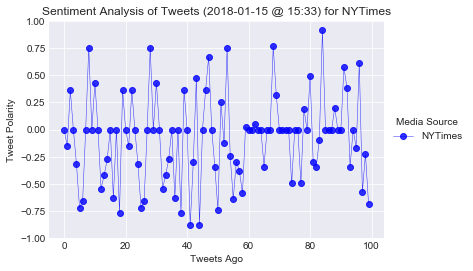

In [33]:
# Loop each Media Sources to Plot individually 

for user in targets:
    
    name_news = select_data.loc[select_data['Target'] == user]
        
    plt.plot(np.arange(len(data_CNN['Compound'])),
            name_news['Compound'], marker = 'o', linewidth = 0.5,
            alpha = 0.8, color = 'b', label = user)
        
    now = datetime.now()
    now = now.strftime("%Y-%m-%d @ %H:%M")
    plt.title("Sentiment Analysis of Tweets ({}) for {}".format(now, user))
    plt.ylabel("Tweet Polarity")
    plt.xlabel("Tweets Ago")
    plt.ylim(-1, 1)
    art = []
    plt.style.use('seaborn-darkgrid')
    plt.legend(title= 'Media Source', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(f"SentimentAnalysisFor{user}", additional_artists=art, bbox_inches="tight")
    plt.show()

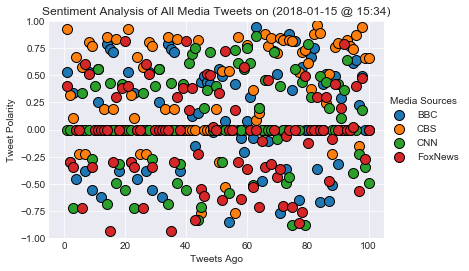

In [34]:
# Make a plot of all Media Sources together

compound_news = big_data.pivot(index='Tweet Ago', columns='Target', values='Compound')
compound_news.plot(marker = 'o', grid= True, style = ' ', ms = 10, markeredgecolor= 'black')

now = datetime.now()
now = now.strftime("%Y-%m-%d @ %H:%M")
plt.title('Sentiment Analysis of All Media Tweets on ({})'.format(now))
plt.ylabel('Tweet Polarity')
plt.xlabel('Tweets Ago')

plt.ylim(-1, 1)
plt.xlim(-5, 105)
plt.legend(title = 'Media Sources', bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0.1)

plt.savefig(f"SentimentAnalysisAllMediaTweets", additional_artists=art, bbox_inches="tight")
plt.show()

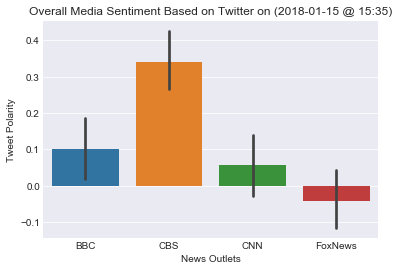

In [35]:
# Make a bar plot of Compund Data of Media Sources together

sns.barplot(x='Target', y='Compound', data = big_data)

now = datetime.now()
now = now.strftime("%Y-%m-%d @ %H:%M")
plt.title('Overall Media Sentiment Based on Twitter on ({})'.format(now))

plt.ylabel('Tweet Polarity')
plt.xlabel('News Outlets')
plt.savefig(f"MediaSentimentsBarplot", additional_artists=art, bbox_inches="tight")
plt.show()